In [103]:
! pip install datasets transformers
! pip install accelerate -U
! pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 6.1 MB/s eta 0:00:0000:01
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.29.3
    Uninstalling accelerate-0.29.3:
      Successfully uninstalled accelerate-0.29.3


In [104]:
import os
import numpy as np
import cv2
import datasets
from datasets import load_dataset
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader, Subset, random_split
import torchvision.transforms as transforms
import datasets
import pandas as pd
from datasets import load_dataset, DatasetDict, load_metric
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt
from torchvision.utils import make_grid 
import time
from transformers import ViTFeatureExtractor, AutoImageProcessor

2024-05-13 03:19:15.956810: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-13 03:19:15.956931: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-13 03:19:16.078961: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [105]:
# Random seed for PyTorch
torch.manual_seed(42)

In [106]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [107]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [108]:
# Load dataset
img_path = "/kaggle/input/data"
data = load_dataset("imagefolder", data_dir=img_path)

Resolving data files:   0%|          | 0/1792 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

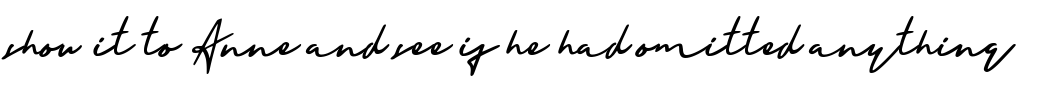

In [109]:
# random image
data['train'][1001]['image']

In [110]:
# Generate all labels
labels = data['train'].features['label']
labels

ClassLabel(names=['AguafinaScript', 'AlexBrush', 'Allura', 'Canterbury', 'GreatVibes', 'Holligate Signature', 'I Love Glitter', 'James Fajardo', 'OpenSans', 'alsscrp'], id=None)

In [111]:
# Split data into train, test validation --
data_ds = data['train'].train_test_split(shuffle = True, seed = 0, test_size=0.3)
data_test_ds = data_ds['test'].train_test_split(shuffle = True, seed = 0, test_size=0.5)

final_dataset = DatasetDict({
    'train': data_ds['train'],
    'validation': data_test_ds['train'],
    'test': data_test_ds['test']
})
final_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1254
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 269
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 269
    })
})

In [112]:
model_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_path)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [113]:
# final_dataset have raw images, convert into embeddings
def transform(batch):
    inputs = feature_extractor([x for x in batch['image']], return_tensors='pt')
    inputs['label'] = batch['label']
    return inputs

prepared_ds = final_dataset.with_transform(transform)

In [114]:
prepared_ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1254
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 269
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 269
    })
})

In [115]:
prepared_ds['train'].features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['AguafinaScript', 'AlexBrush', 'Allura', 'Canterbury', 'GreatVibes', 'Holligate Signature', 'I Love Glitter', 'James Fajardo', 'OpenSans', 'alsscrp'], id=None)}

In [116]:
def collateFunction(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

In [117]:
metric = load_metric("accuracy")

# compute accuracy
def computeMetrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

/tmp/ipykernel_34/802511129.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")
/opt/conda/lib/python3.10/site-packages/datasets/load.py:756: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [118]:
# ViT for Image classification model
from transformers import ViTForImageClassification
from transformers import AutoImageProcessor


labels = prepared_ds['train'].features['label'].names

model = ViTForImageClassification.from_pretrained(
    model_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [119]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./vit-base",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=5,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

In [120]:
from transformers import Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collateFunction,
    compute_metrics=computeMetrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["validation"],
    tokenizer=feature_extractor,
)

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [121]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss,Accuracy
100,0.148000,0.129467,1.000000
200,0.068100,0.071123,1.000000


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


***** train metrics *****
  epoch                    =         5.0
  total_flos               = 452538591GF
  train_loss               =      0.3645
  train_runtime            =  0:02:53.96
  train_samples_per_second =      36.041
  train_steps_per_second   =        1.15


In [122]:
def softmax(logits):
    exp_logits = np.exp(logits)
    probabilities = exp_logits / np.sum(exp_logits)
    return probabilities

In [123]:
output = trainer.predict(prepared_ds['test'])

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [124]:
output.predictions.shape

(269, 10)

In [125]:
label_ordering = prepared_ds['train'].features['label'].names

target_labels = output.label_ids
logits = output.predictions
log_probs = softmax(logits)
prediction_labels = np.argmax(log_probs, axis=-1)
print(f"Accuracy ->  {accuracy_score(target_labels, prediction_labels)}")

Accuracy ->  1.0


In [127]:
from sklearn.metrics import classification_report
report = classification_report(target_labels, prediction_labels, target_names=label_ordering)
print(report)

                     precision    recall  f1-score   support

     AguafinaScript       1.00      1.00      1.00        20
          AlexBrush       1.00      1.00      1.00        24
             Allura       1.00      1.00      1.00        23
         Canterbury       1.00      1.00      1.00        30
         GreatVibes       1.00      1.00      1.00        23
Holligate Signature       1.00      1.00      1.00        36
     I Love Glitter       1.00      1.00      1.00        26
      James Fajardo       1.00      1.00      1.00        34
           OpenSans       1.00      1.00      1.00        16
            alsscrp       1.00      1.00      1.00        37

           accuracy                           1.00       269
          macro avg       1.00      1.00      1.00       269
       weighted avg       1.00      1.00      1.00       269

